In [2]:
import numpy as np

# 1 Preparation

## What is the purpose of an activation function in NN in general?
The activation function decides what output the neuron should give in relation to its input values and weights.

## What’s the advantage of e.g. sigmoid over the step function (threshold function)?
The sigmoid function allows for a smoother activation rather than an on-off activation as seen in the step function.


## How does sigmoid look like (the formula as well as the graph)?

Formula:
$\sigma(x) = \frac{1}{1+e^{-x}}$

with e being Euler's number. 

Graph

![Graph of the Simoid function](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sigmoid-function-2.svg/2000px-Sigmoid-function-2.svg.png)

Source: Wikipedia

## What is the derivative of sigmoid?

$\sigma(x)' = \sigma(x)(1 - \sigma(x))$

## Implementation

In [3]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of Sigmoid function
def sigmoidprime(x):
    return sigmoid(x)*(1-sigmoid(x))

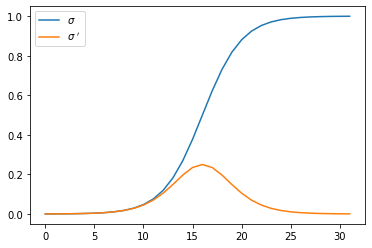

In [21]:
# Quick visualization

import matplotlib.pyplot as plt

values = np.arange(-8,8, 0.5)
plt.plot(sigmoid(values))
plt.plot(sigmoidprime(values))
plt.legend(["$\sigma$", "$\sigma \ '$"])
plt.show()

# 3 Perceptron

In [ ]:
class Perceptron():
    self.alpha = 0.01
    
    # Calculates the activation
    def forward_step(self, inputs):
        pass
    
    # Update the weights
    def update(self, delta):
        

In [ ]:
class MLP():
    def forward_step():
        pass
    
    def backprop_step():
        pass

In [16]:
# Training

training_data = np.array([(1, 1), (1, 0), (0, 1), (0, 0)])

# Ensure the input has the appropriate format
assert training_data.shape == (4, 2)

